## Model set-up

In [1]:
## Import packages

import pandas as pd
import numpy as np
import json
import random

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split

In [5]:
## Import metadata

book_metadata_url = "/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_book/metadata"
movie_metadata_url = "/Users/egmac/code/arostagnat/BookMatch/data/raw_data/raw_movies/metadata"

book_details = pd.read_json(book_metadata_url+".json",lines=True)
movie_details = pd.read_json(movie_metadata_url+".json",lines=True)

In [60]:
book_details_copy = book_details.copy().drop([ 'url', 'authors', 'lang', 'img', 'year','description'],axis=1)
movie_details_copy = movie_details.copy().drop([ 'directedBy', 'starring', 'dateAdded', 'avgRating', 'imdbId'],axis=1)
data_details = pd.concat([book_details_copy,movie_details_copy])
data_details.head(3)

,item_id,title
0,16827462,The Fault in Our Stars
1,2792775,"The Hunger Games (The Hunger Games, #1)"
2,8812783,"Mockingjay (The Hunger Games, #3)"


In [52]:
movie_details.columns

Index(['title', 'directedBy', 'starring', 'dateAdded', 'avgRating', 'imdbId',
       'item_id'],
      dtype='object')

In [9]:
## Import data. Make sure to replace sample data with full data when available
book_URL = '/Users/egmac/code/arostagnat/BookMatch/data/raw_data/sample_books_reviews_clean.csv'
movie_URL = '/Users/egmac/code/arostagnat/BookMatch/data/raw_data/sample_movies_reviews_clean.csv'
book_data = pd.read_csv(book_URL,names=["index","item_id","txt"],header=0,index_col="index",usecols=["index","item_id","txt"])
movie_data = pd.read_csv(movie_URL,names=["index","item_id","txt"],header=0,index_col="index",usecols=["index","item_id","txt"])

In [10]:
## Set tag for book / movie
book_data["type"] = 1
movie_data["type"] = 0

In [117]:
## Concatenate book and movies data
data = pd.concat([movie_data,book_data])
data = data.reset_index()
data.tail(3)

,index,item_id,txt,type
161997,5305850,56654039,"['dont', 'want', 'say', 'im', 'disappoint', 'b...",1
161998,5300072,55264711,"['sign', 'paperback', 'one', 'christines', 'fa...",1
161999,5306516,21576687,"['ive', 'recently', 'start', 'think', 'hold', ...",1


In [ ]:
# book_data.head()
# movie_data.head()

In [13]:
## Reset index to match document tagging
data_copy = data.copy()
data_copy = data.reset_index()
data_copy.index.name = "new_index"

In [15]:
## Add required tagging
data_tag = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["txt"])]
print(f"data_tag: {len(data_tag)}")

data_tag: 162000


In [16]:
## Setup Doc2Vec model
model = Doc2Vec(vector_size=50, min_count=5)

In [17]:
## Build vocab
model.build_vocab(data_tag)

In [18]:
## Train model
model.train(data_tag,epochs=50,word_count=0,total_examples=model.corpus_count)

In [19]:
## Confirm output of txt column
print(data.loc[1]["txt"])
type(data.loc[1]["txt"])

['watch', 'evil', 'find', 'movie', 'okay', 'scary', 'though', 'little', 'jumpy', 'watch', 'end', 'though', 'warn', 'make', 'sure', 'alone', 'watch', 'movie', 'point', 'rachel', 'well', 'sure', 'remote', 'hand', 'finger', 'stop', 'button', 'aidans', 'father', 'alone', 'apartment', 'tv', 'turn', 'youll', 'see', 'scar', 'saw', 'samara', 'face', 'dvd', 'freeze', 'stick', 'face', 'make', 'mistake', 'watch', 'alone', 'idea', 'happen', 'aidans', 'father', 'rest', 'movie', 'there', 'way', 'im', 'watch', 'sequel']


str

In [20]:
## Obtain inferred vectors for each film / book
vectors_list = []

for i in data.index:
    text = data.loc[i]["txt"]
    text_cleaned = text.strip('[]').replace("'","").replace(' ', '').split(',')
    inferred_vector = model.infer_vector(text_cleaned)
    vectors_list.append(inferred_vector)

In [118]:
## Add vectors to data_train
data["vector"] = vectors_list

In [110]:
# data.head(3)
data.shape

(162000, 5)

In [458]:
## Obtain top 10 similar items for each film / book
top_book_dict = {}

for i in data.index[:20]:
    vector = data.loc[i]["vector"]
    similar_items = model.dv.most_similar([vector],topn=1000)
    results = pd.DataFrame(similar_items,columns=["new_index","cosine"]).set_index("new_index")
    results = results.merge(data_copy[["item_id","type"]],how="left",on="new_index")
    results_copy = results[results.type == 1].sort_values(by=["cosine"],ascending=False).reset_index()
    top_book_dict[i] = results_copy.loc[0]

In [ ]:
## Add top books and cosines to data_train

top_books = [top_book_dict[i]["item_id"] for i in data_train.index]
top_cosine = [top_book_dict[i]["cosine"] for i in data_train.index]

data["top_book"] = top_books
data["cosine"] = top_cosine

In [ ]:
data_test.loc[movie_index]["item_id"]

In [61]:
data.item_id = data.item_id.astype(int)
data_details.item_id = data_details.item_id.astype(int)

In [119]:
data = data.merge(data_details[["title","item_id"]].drop_duplicates(subset=['item_id']),how="left",on="item_id").dropna()
data.head(3)

,index,item_id,txt,type,vector,title
0,43660,8981,"['bore', 'pretentious', 'wow', 'double', 'wow'...",0,"[-0.11073571, -0.21480657, -0.055868283, -0.00...",Closer (2004)
1,87278,5679,"['watch', 'evil', 'find', 'movie', 'okay', 'sc...",0,"[-0.008866307, 0.0059268055, 0.00097568275, -0...","Ring, The (2002)"
2,14317,3427,"['smart', 'career', 'move', 'clint', 'clint', ...",0,"[0.0069195773, 0.0010076916, -0.00802189, 0.00...",Coogan's Bluff (1968)


## Model results

In [71]:
## Define formula to provide recommendations for random vectors

def get_book_recc(movie_id):
    
    movie_index = data[data["item_id"] == movie_id].index[0]
    
    text = data.loc[movie_index]["txt"]
    text_cleaned = text.strip('[]').replace("'","").replace(' ', '').split(',')
    
    inferred_vector = model.infer_vector(text_cleaned)
    similar_items = model.dv.most_similar([inferred_vector], topn=1000)
    
    results = pd.DataFrame(similar_items,columns=["new_index","cosine"]).set_index("new_index")
    results = results.merge(data_copy[["item_id","type"]],how="left",on="new_index")
    results_copy = results[results.type == 1].sort_values(by=["cosine"],ascending=False).reset_index()
    book_id_1 = results_copy.loc[0]["item_id"]
    book_id_2 = results_copy.loc[1]["item_id"]
    book_id_3 = results_copy.loc[2]["item_id"]
    book_id_4 = results_copy.loc[3]["item_id"]
    book_id_5 = results_copy.loc[4]["item_id"]
    
    movie_name = data_details[data_details["item_id"]==movie_id]["title"].to_string()
    book_1_name = data_details[data_details["item_id"]==book_id_1]["title"].to_string()
    book_2_name = data_details[data_details["item_id"]==book_id_2]["title"].to_string()
    book_3_name = data_details[data_details["item_id"]==book_id_3]["title"].to_string()
    book_4_name = data_details[data_details["item_id"]==book_id_4]["title"].to_string()
    book_5_name = data_details[data_details["item_id"]==book_id_5]["title"].to_string()
    
    print(f"""===== Book recommendations for {movie_name} =====
    1. {book_1_name}
    2. {book_2_name}
    3. {book_3_name}
    4. {book_4_name}
    5. {book_5_name}""")

In [26]:
keyword = "potter"
sample = data_movies[data_movies["title"].str.contains(keyword,case=False,na=False)].item_id

In [72]:
potter = [5816,40815,54001,69844]

for item in potter:
    get_book_recc(movie_id=item)

===== Book recommendations for 5718    Harry Potter and the Chamber of Secrets (2002) =====
    1. 4447    Rock Hard (Rock Kiss, #2)
    2. 378    The Deal (Off-Campus, #1)
    3. 1705    The Bazaar of Bad Dreams
    4. 1577    Missoula: Rape and the Justice System in a Col...
    5. 3041    Lost Stars
===== Book recommendations for 10623    Harry Potter and the Goblet of Fire (2005) =====
    1. 4178    America's First Daughter
    2. 7598    The Dead Girls of Hysteria Hall
    3. 375    Between the World and Me
    4. 784    P.S. I Like You
    5. 2984    Friends With Boys
===== Book recommendations for 12005    Harry Potter and the Order of the Phoenix (2007) =====
    1. 315    Stardust
    2. 584    The Eye of the World (Wheel of Time, #1)
    3. 9038    The Last Command (Star Wars: The Thrawn Trilog...
    4. 2    Mockingjay (The Hunger Games, #3)
    5. 317    The Brief Wondrous Life of Oscar Wao
===== Book recommendations for 13988    Harry Potter and the Half-Blood Prince (200

## Data visualization using PCA

In [149]:
## Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [176]:
## Set-up of data inputs. Note that X must comprise solely vectors

sample_size = 1000

if sample_size < 161986:
    extract = data.sample(n=sample_size)
    X = pd.DataFrame(extract.vector.values.tolist())
    y_type = extract.type
    y_title = extract.title
else:
    X = pd.DataFrame(data.vector.values.tolist())
    y_type = data.type
    y_title = data.title

print(f"X shape: {X.shape}, y type: {y_type.shape}, y title: {y_title.shape}")

X shape: (1000, 50), y type: (1000,), y title: (1000,)


In [177]:
## Initialization of TSNE model

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

tsne_df = pd.DataFrame()
tsne_df["type"] = y_type
tsne_df["title"] = y_title
tsne_df["comp-1"] = z[:,0]
tsne_df["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.013924
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.799431
[t-SNE] KL divergence after 1000 iterations: 2.224449


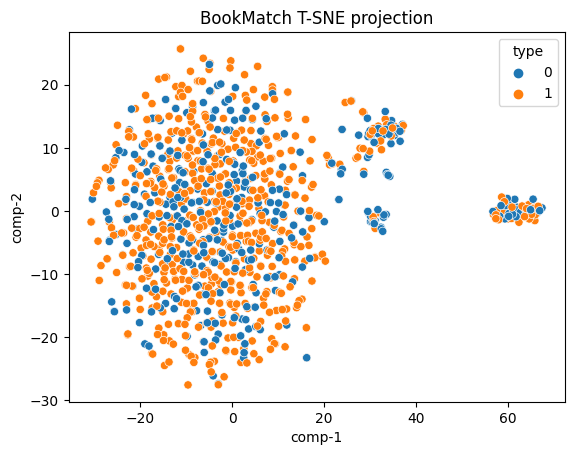

In [178]:
## Visualization of results

titles = tsne_df["title"]
comp_1 = tsne_df["comp-1"]
comp_2 = tsne_df["comp-2"]

kwargs = dict (linestyle='--', color='b', marker ='o', linewidth=1.2, markersize=2)

sns.scatterplot(x="comp-1", y="comp-2", hue="type",
                data=tsne_df).set(title="BookMatch T-SNE projection");

# for i, word in enumerate(titles):
#     plt.annotate(word,xy=(comp_1[i]+0.5,comp_2[i]+0.5))